# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 3

**Author 1 (sciper):** Morand Nathann (296190)
**Author 2 (sciper):** David Croce (327277)
**Author 3 (sciper):** Felipe Ramirez (331471)

**Release date:** 02.04.2025   
**Due date:** 16.04.2025 (11:59 pm)


## Key Submission Guidelines:

- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`  
- **Only groups of three will be accepted**, except in exceptional circumstances.  
- **You are not allowed to use any libraries** other than those provided in this notebook.  
- **TAs must be able to run your code from start to finish without any issues.**  
- **Failure to follow these guidelines may result in point deductions** during grading.  


[iapr]: https://github.com/LTS5/iapr

In [1]:
!pip install numpy -q
!pip install matplotlib -q
!pip install pillow -q
!pip install pandas -q
!pip install scikit-learn -q
!pip install tqdm -q
!pip install gdown -q

You should consider upgrading via the 'C:\Users\Nathann\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Nathann\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Nathann\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Nathann\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Nathann\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Nathann\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'C:\Users\Nathann\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade

In [2]:
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

Please take note that PyTorch will be utilized in this lab. PyTorch is a widely recognized library for deep learning. Prior to commencing the lab, we kindly ask you to review this quick tutorial available [here](https://pytorch.org/tutorials/beginner/basics/intro.html).

In [3]:
import platform

# Get os name
os_name = platform.system().lower()

# OS X
if os_name == 'darwin':
    print("Detected OS X")
    %pip install torch torchvision torchaudio -q
    
#Windows
elif os_name == 'windows':
    print("Detected Windows")
    %pip install torch torchvision torchaudio -q
    
# Linux  
else:
    print("Detected Linux")
    %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu -q

Detected Windows
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Nathann\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
# Import main packages
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Optional, Callable
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf

from utils.lab_03_utils import *

# Real-World Image Classification in Histopathology [30 points]

Supervised learning for classifying histopathology images, despite its capabilities, faces significant challenges. A primary obstacle is its reliance on labeled data, which is often scarce and costly to acquire due to the need for expert annotations. This scarcity can impede model performance, particularly when dealing with uncommon diseases or subtle pathological patterns. Moreover, supervised models may struggle with generalization to unseen data or variations in tissue staining protocols. 

This lab will concentrate on constructing classification models tailored for histopathology using the least labeled data possible. Since the lab does not center on computing descriptors for the images, only image features will be provided. Specifically, we utilized [CTransPath](https://github.com/Xiyue-Wang/TransPath), one of the most robust and precise existing image feature extractors in histopathology, as the descriptor. Your focus will be on classifying these features for downstream tasks crucial to histopathological analysis.

Before starting, download the data by running the following cell and make sure the data are located as follows:
```code
├── labs
│   └──lab_03_iapr.ipynb
└── data
    └── data_lab_03
        ├── part_01
        │    ├── k16_train.pth
        │    ├── k16_val.pth
        │    ├── k16_test.pth
        │    ├── k16.png
        │    └── k16.svg
        └── part_02
            ├── acinar.png
            ├── solid.png
            ├── wsi.png
            ├── DHMC_0001.png
            ├── DHMC_0007.png
            ├── dhmc_train.pth
            ├── dhmc_val.pth
            └── dhmc_test.pth
```

In [5]:
download_data()

## Part 1 - Tumor, Stroma Classification in Colorectal Cancer Histopathology (11 points)

Colorectal cancer ranks among the most prevalent cancers affecting both men and women. Accurate diagnosis, supplemented with prognostic and predictive biomarker information, plays a pivotal role in patient monitoring and facilitating personalized treatment approaches. One crucial biomarker is the Tumor/Stroma ratio (TSR) observed in unhealthy colon tissues. This ratio serves as an indicator of cancer invasiveness, with higher ratios correlating to increased invasiveness and, consequently, diminished patient survival probabilities.

Traditionally, pathologists assess the TSR by visually inspecting unhealthy tissue samples under a microscope, relying on their expertise to estimate the ratio. However, given the large volume of samples and the occasional lack of precision in estimations, there arises a pressing need for automated recognition of various tissue types within histological images. The development of a multi-class classifier becomes imperative to accurately identify the diverse tissue types present. Typically, these tissue types include TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE, and EMPTY (background).

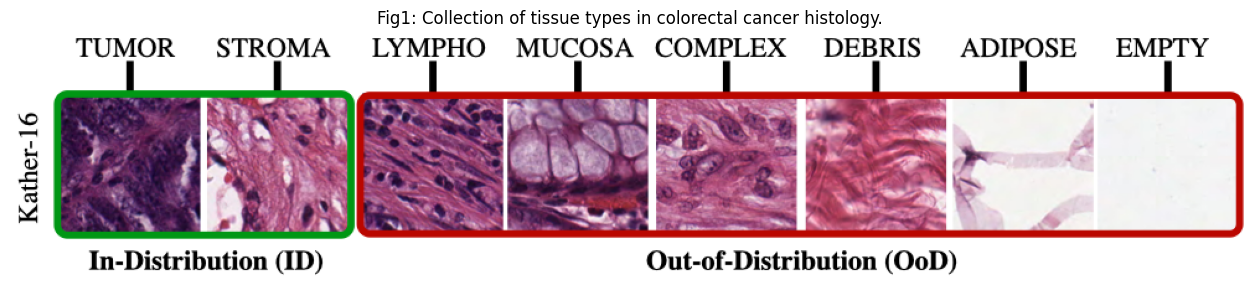

In [6]:
show_figure("../data/data_lab_03/part_01/k16.png","Fig1: Collection of tissue types in colorectal cancer histology.",(16,4))

Until now, state-of-the-art methodologies in histology have predominantly relied on deep-learning-based supervised learning techniques. However, a significant drawback of such an approach lies in the requirement for access to a meticulously annotated training dataset. Annotating histological data poses considerable challenges—it is a time-consuming process that demands the expertise of pathologists. Moreover, annotators are compelled to label every tissue type, even though only two (TUMOR and STROMA) are of primary interest.

To address these challenges, we propose an alternative approach. To streamline the annotation process, we task the annotator with labeling only the tissues of interest (TUMOR and STROMA), and discarding the rest. Subsequently, we aim to train a binary classifier capable of automatically recognizing these specific tissues during testing. This novel approach seeks to alleviate the burden of annotation while still enabling accurate identification of the critical tissue types. In this section, we will proceed with implementing and evaluating this proposed methodology.

In [7]:
train_x, train_y = load_data("k16_train.pth")
val_x, val_y = load_data("k16_val.pth")

Distribution of data in train set
#Tumor examples: 439
#Stroma examples: 439
Distribution of data in val set
#Tumor examples: 93
#Stroma examples: 93


### 1.1 Binary classifier with Mahalanobis distance [2.5 pts]

Your task is to construct this binary classifier utilizing the Mahalanobis distance as taught in class. Begin by executing the cell below to load the training and validation features for TUMOR and STROMA. These features have been computed using a self-supervised model tailored for histopathology, known as CTransPath. Note that label `0` corresponds to TUMOR and label `1` to STROMA:

* **Q1 (1 pt)**: Complete the `fit` method in `MahalanobisClassifier`. This method calculates the parameters necessary for the Mahalanobis Classifier when fitted to the training data.
* **Q2 (1 pt)**: Complete the `predict` method in `MahalanobisClassifier`. This method is responsible for predicting the class for each test feature as well as the distance to class means using the Mahalanobis distance method.

**Note**: It is forbidden to use any prebuilt Mahalanobis distance function. You may only use `LedoitWolf` in `sklearn.covariance` for computing a stable covariance matrix.

In [8]:
class MahalanobisClassifier:
    """Mahalanobis based classifer"""

    def __init__(self):
        """
        Attributes:
            means (torch.tensor): (n_classes, d) Mean of the features for each class
            inv_covs (torch.tensor): (n_classes, d, d) Inverse of covariance matrix across d features for each class   
        """
        super().__init__()
        self.means = None
        self.inv_covs = None
        
    def fit(self, train_x : torch.Tensor, train_y : torch.Tensor):
        """Computes parameters for Mahalanobis Classifier (self.mean and self.cov), fitted on the training data.

        Args:
            train_x (torch.Tensor): (N, d) The tensor of training features
            train_y (torch.Tensor): (N,) The tensor of training labels
        """

        # Define number of classes
        n_classes = len(np.unique(np.unique(train_y)))
        n, d = train_x.shape
        
        # Set default values
        means = torch.zeros((n_classes, d), dtype=train_x.dtype)
        inv_covs = torch.ones((n_classes, d, d), dtype=train_x.dtype)
        
        # ------------------
        for cls in range(n_classes):
            # Select samples of the current class
            class_features = train_x[train_y == cls]
            # Compute mean
            class_mean = class_features.mean(dim=0)
            means[cls] = class_mean

            # Use LedoitWolf to compute covariance and invert it
            lw = LedoitWolf().fit(class_features.numpy())
            cov = lw.covariance_
            inv_cov = np.linalg.inv(cov)
            inv_covs[cls] = torch.tensor(inv_cov, dtype=train_x.dtype)
        # ------------------

        self.means = means
        self.inv_covs = inv_covs



    def predict(self, test_x : torch.Tensor) -> torch.Tensor:
        """Predicts the class of every test feature, using the Mahalanobis Distance

        Args:
            test_x (torch.Tensor): (N, d) The tensor of test features

        Returns:
            preds (torch.Tensor): (N,) The predictions tensor (id of the predicted class {0, 1, ..., n_classes-1})
            dists (torch.Tensor): (N, n_classes) Mahalanobis distance from sample to class means
        """

        # Define default output value
        N, d = test_x.shape
        dists = torch.zeros((N, self.means.shape[0]), dtype=test_x.dtype)
        preds = torch.zeros(N, dtype=test_x.dtype)

        # ------------------
        for c in range(self.means.shape[0]):
            mu = self.means[c]
            inv_cov = self.inv_covs[c]

            # Subtract class mean
            diff = test_x - mu  # (N, d)

            # Mahalanobis distance: (x - mu)^T Σ⁻¹ (x - mu)
            # Use batch matrix operations: (diff @ inv_cov) * diff → sum over d
            left = torch.matmul(diff, inv_cov)  # (N, d)
            dist_c = (left * diff).sum(dim=1)   # (N,)
            dists[:, c] = dist_c
        preds = torch.argmin(dists, dim=1)
        # ------------------

        return preds, dists

* **Q3 (0.5 pt)**: After fitting your classifier on the training data, compute the accuracy of the validation data. Are you satisfied with the results?
    * **Answer**: the result are impressive given the simplicity of the code but we have missclasiffication which could lead to missing a tumor.

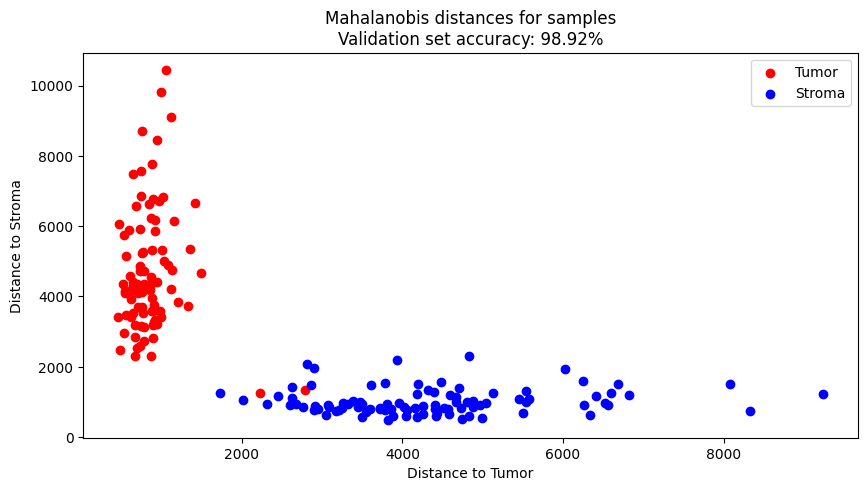

In [9]:
################################################################
############################ TEST ##############################
################################################################

mahalanobis_classifier(
    MahalanobisClassifier, train_x, train_y, val_x, val_y,
    cls_name=["Tumor", "Stroma"], colors=["r", "b"],
)

### 1.2 Out-of-Distribution detection with Mahalanobis distance [3.5 pts]

Your classifier appears to perform well. However, during testing, it's possible for other tissue types to be present, which cannot be manually filtered out. Moreover, these tissue types may not be recognized by the model as they fall outside the labeled training distribution (It is the consequence of the laziness of the annotators ;)). Therefore, it's crucial to filter out these out-of-distribution (OoD) samples.

One approach to OoD detection involves computing an OoD-ness score for each test example. This score should be low for in-distribution (ID) examples and high for OoDs. Subsequently, a threshold is defined, for which any example with a greater OoD-ness is discarded, while those below it are forwarded to the model for prediction. An example of an OoD-ness score is the minimum Mahalanobis distance to means.

* **Q1 (0.5 pts)**: Why do you think the minimum Mahalanobis distance is a good OoD-ness score?
    * **Answer**:  It's a good OoD-ness score because it measures how far a sample is from the closest known class while considering feature correlations. In-distribution samples have low distances to at least one class, while OoD samples have high distances to all classes. Setting a threshold on this distance helps filter out OoD samples effectively.

Start by running the cell below to load the test set. It comprises TUMOR and STROMA samples, along with other tissue types. Note that OoD tissues types are labeled to `-1`.

In [10]:
test_x, test_y = load_data("k16_test.pth")

Distribution of data in test set
#Tumor examples: 93
#Stroma examples: 93
#OoD examples: 558


* **Q2 (0.5 pts)**: We create a new classifier `MahalanobisOODClassifier` that inherits from the previous one. Reimplement the function `predict` such that it returns as well the OoD scores. We define the `ood_scores` as the minimum Mahalanobis distance from the classifier. Your accuracy results should be the same as before.

In [11]:
class MahalanobisOODClassifier(MahalanobisClassifier):
    """Predicts the class of every test feature, using the Mahalanobis Distance

    Args:
        test_x (torch.Tensor): (N x d) The tensor of test features

    Returns:
        preds (torch.Tensor): (N,) The predictions tensor (id of the predicted class {0, 1, ..., n_classes-1})
        dists (torch.Tensor): (N, n_classes) Mahalanobis distance from sample to class means
        ood_scores (torch.Tensor): (N,) Score of OoDness as the minimal distance from the sample to classes
    """

    def predict(self, test_x : torch.Tensor) -> torch.Tensor:
        
        # Get super prediction (from MahalanobisClassifier)
        preds, dists = super().predict(test_x=test_x)
        N = preds.shape[0]

        # Assign dummy values to scores
        ood_scores = np.zeros(N)
        
        # ------------------
        for i in range(N):
            # Get the minimum distance to the class means
            ood_scores[i] = dists[i].min()
        # ------------------
        
        return preds, dists, ood_scores



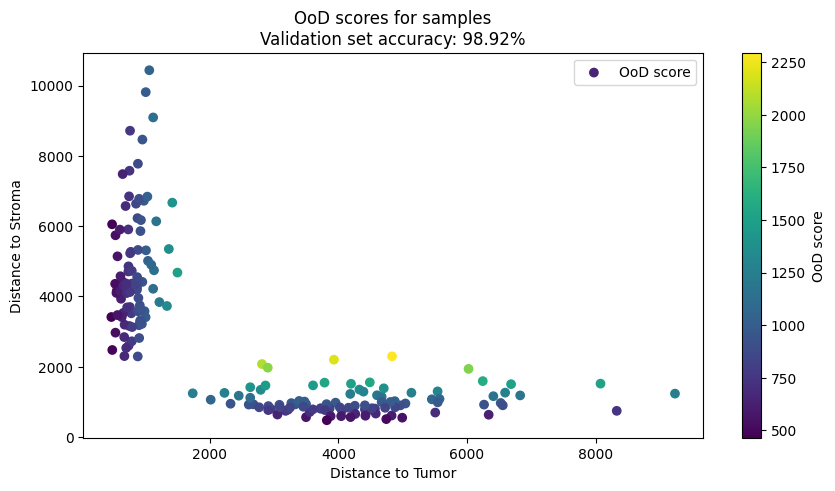

In [12]:
################################################################
############################ TEST ##############################
################################################################

classifier_ood, val_y_ood_scores=mahalanobis_ood_classifier(
    MahalanobisOODClassifier, train_x, train_y, val_x, val_y,
    cls_name=["Tumor", "Stroma"], colors=["r", "b"],
)


* **Q3 (0.5 pts)**: Based on the validation set OoD scores, determine a threshold for the minimum Mahalanobis distance such that 95% of the validation samples are identified as ID.

In [13]:
def get_ood_threshold(ood_scores, quantile=0.95):
    """ Get OoD threshold based on measured scores and quantile

    Args:
        ood_scores (torch.Tensor): (N, ) N measured OoDness scores
        quantile (float): Percentage of samples that are considered as in distribution
    """

    # Set default value
    threshold = 0

    # ------------------
    if isinstance(ood_scores, torch.Tensor):
        ood_scores = ood_scores.cpu().numpy()

    sorted = np.sort(ood_scores)
    threshold = sorted[int(quantile * len(sorted))]
    # ------------------

    return threshold

Validation threshold 95% = 1513.65


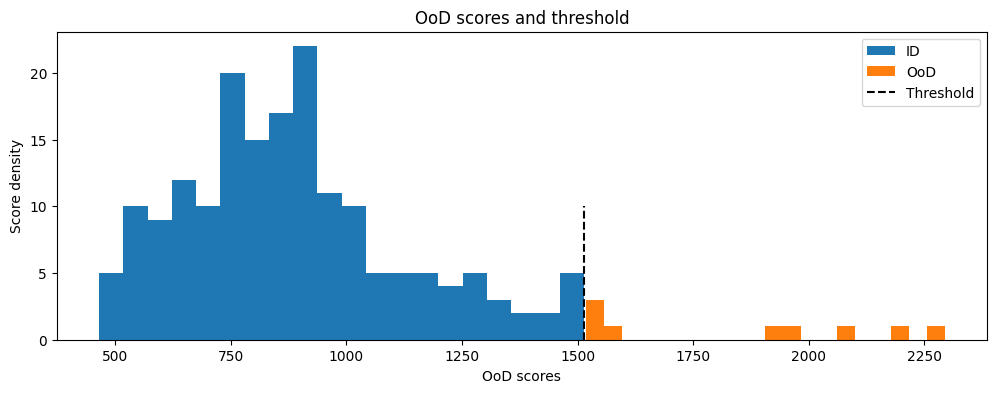

In [14]:
################################################################
############################ TEST ##############################
################################################################

threshold_val = check_threshold(get_ood_threshold,val_y_ood_scores)

* **Q4 (2 pts)**: Complete the function `compute_metrics` that computes the recall for TUMOR, STROMA, and OoD examples as well as the average recall over the 3 classes. To do so, you need to consider OoDs as a third class by assigning the prediction `-1` to filtered-out examples based on your threshold. Based on your results, conclude on the feasibility of the proposed pipeline. Propose a solution that would require the least annotation possible but that could significantly increase your OoD recall.
    * **Answer**: The model shows strong performance with recall greater than 90% for stroma and tumor. OoD recall reaches 86%, which is promising but still insufficient in a medical context where missing rare or unknown tissue types could be critical. To improve OoD detection with minimal annotation effort, we suggest using an active learning strategy. The model would flag uncertain or borderline samples—likely OoDs—for manual review. This focuses annotation on the most informative cases, boosting performance without requiring large-scale labeling.

In [15]:
def compute_metrics(y, y_hat, ood_scores, threshold):
    """ Compute recall for tumor, stroma, and OoD as well as the average recall.

    Args:
        y (torch.Tensor): (N) Class ground truth {-1, 0, 1, ..., n_classes}
        y_hat (torch.Tensor): (N,) Class predictions {0, 1, ..., n_classes}
        ood_scores (torch.Tensor): (N, ) N measured OoDness scores
        threshold (float): OoD threshold
    """
    # Define variable with dummy values 
    recall_tumor = 0
    recall_stroma = 0
    recall_ood = 0
    avg_recall = 0
    
    # Convert to NumPy arrays if they are PyTorch tensors
    if isinstance(y, torch.Tensor):
        y = y.cpu().numpy()
    if isinstance(y_hat, torch.Tensor):
        y_hat = y_hat.cpu().numpy()
    if isinstance(ood_scores, torch.Tensor):
        ood_scores = ood_scores.cpu().numpy()

    for i in range(len(y_hat)):
        if ood_scores[i] > threshold:
            y_hat[i] = -1  # Assign -1 to samples classified as OoD
    # Function to compute recall safely
    def compute_recall(y_true, y_pred, target_class):
        true_positives = np.sum(np.logical_and(y_true == target_class, y_pred == target_class))
        actual_positives = np.sum(y_true == target_class)
        return true_positives / max(actual_positives, 1)  # Avoid division by zero

    # Compute recall for each class
    recall_tumor = compute_recall(y, y_hat, 1)  # Tumor class
    recall_stroma = compute_recall(y, y_hat, 0)  # Stroma class
    recall_ood = compute_recall(y, y_hat, -1)    # Out-of-Distribution class

    # Compute average recall
    avg_recall = (recall_tumor + recall_stroma + recall_ood) / 3

    return recall_tumor, recall_stroma, recall_ood, avg_recall


Tumor recall: 92.47%
Stroma recall: 98.92%
OoD recall: 86.02%
Average recall: 92.47%


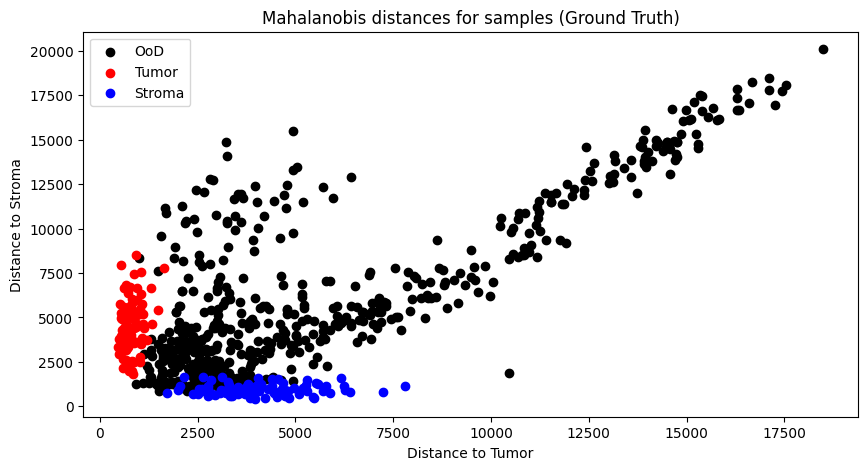

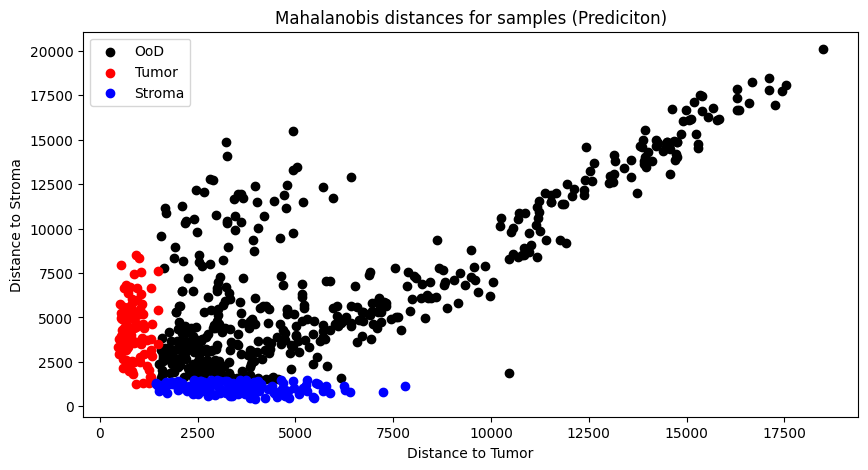

In [16]:
################################################################
############################ TEST ##############################
################################################################

# Predictions on test set
test_y_dist, test_y_hat = eval_test(classifier_ood,compute_metrics, test_x,test_y,threshold_val)

### 1.3 Out-of-Distribution detection with k-NN [5 pts]

Let's explore another technique based on k-Nearest Neighbors (k-NN). The features utilized have been extracted from a self-supervised model, known for their efficacy as k-NN classifiers. This motivates us to implement a k-NN classifier for identifying TUMOR and STROMA. Additionally, the k-NN distance serves as a suitable OoD-ness score, aligning well with our task requirements.

* **Q1 (2 pts)**: Complete the `fit` and `predict` functions in `kNNClassifier`. Also, assign your own handcrafted OoD score in `predict`. We recommend to use `top_k` function from torch ([doc](https://pytorch.org/docs/stable/generated/torch.topk.html)). When using k>1, use majority voting to select the winning class.

**Note**: It is forbidden to use any prebuilt k-NN classifier function.

In [17]:
class kNNClassifier:
    """k-NN based classifier"""

    def __init__(self, k : int):
        """
        Args:
            k (int): The number of neighbors to consider for the classification
            features (torch.Tensor): (N, d) feature of the N train samples
            labels (torch.Tensor): (N,) labels for train samples
        """
        self.k = k
        self.features = None
        self.labels = None

    def fit(self, train_x : torch.Tensor, train_y : torch.Tensor):
        """Store training data parameters (features and labels) for k-NN classifier.

        Args:
            train_x (torch.Tensor): (N, d) The tensor of training features
            train_y (torch.Tensor): (N,) The tensor of training labels
        """
        
        # Get size and default values
        N, d = train_x.shape
        features = torch.zeros((N, d))
        labels = torch.zeros(N)
        
        # ------------------
        features = train_x
        labels = train_y
        # ------------------

        self.features = features
        self.labels = labels

    def predict(self, test_x : torch.Tensor) -> torch.Tensor:
        """Predicts the class of every test feature, using the k-NN

        Args:
            test_x (torch.Tensor): (N x d) The tensor of test features

        Returns:
            preds (torch.Tensor): (N,) The tensor of class predictions {0, 1, ..., n_classes}
            ood_scores (torch.Tensor): (N,) The OoD score predictions
        """

                
        # Get size and default values
        N, d = test_x.shape
        preds = torch.zeros(N)
        ood_scores = torch.zeros(N)

        # ------------------
        distances = torch.cdist(test_x, self.features)

        # Find indices of the k smallest distances
        k_distances, k_indices = torch.topk(distances, self.k, largest=False, dim=1)

        for i in range(N):
            # Select labels of the k nearest neighbors
            nearest_labels = self.labels[k_indices[i]]

            # Majority voting without Counter
            unique_labels, counts = np.unique(nearest_labels, return_counts=True)
            most_common_label = unique_labels[np.argmax(counts)]
            preds[i] = most_common_label

            # Compute OoD score as the mean distance to the k nearest neighbors
            ood_scores[i] = k_distances[i].mean()
        # ------------------
        
        return preds, ood_scores

* **Q2 (1 pt)**: Find the best `k` among `[1, 3, 5, 9, 15, 25]` based on the validation set. What is the best `k` and accuracy?
    * **Answer**: Best K is 3

In [18]:
# Best k for knn fitting (to find among suggested ks)

def find_best_k(ks,kNNClassifier: Callable,train_x: torch.Tensor, train_y: torch.Tensor, val_x: torch.Tensor, val_y: torch.Tensor):
    best_k = 0
    best_accuracy = 0.
    # Iterate over ks
    for k in ks:

        # ------------------
        classifier_knn = kNNClassifier(k=k)
        classifier_knn.fit(train_x, train_y)
        preds, ood_scores = classifier_knn.predict(val_x)
        acc = accuracy_score(val_y, preds)
        if acc > best_accuracy:
            best_accuracy = acc
            best_k = k
        # ------------------
        
        continue

    return best_k, best_accuracy

In [19]:
################################################################
############################ TEST ##############################
################################################################

best_k, best_accuracy = check_best_k(find_best_k, kNNClassifier,train_x, train_y, val_x, val_y)


Best @ k: 3 -> 99.46% accuracy


* **Q3 (1 pt)**: Compute the threshold such that 95% of validation samples are detected as ID. 

In [20]:
def fit_knn(best_k, train_x, train_y, val_x, val_y):

    # best threshold
    threshold_val = 0
    # Predicted val ood scores
    val_y_ood_scores = torch.zeros(len(val_y))
    classifier = None 
    # ------------------
    classifier = kNNClassifier(k=best_k)
    classifier.fit(train_x, train_y)
    val_y_ood_scores = classifier.predict(val_x)[1]
    q = 0.95
    threshold_val = get_ood_threshold(ood_scores=val_y_ood_scores, quantile=q)
    # ------------------

    return classifier, threshold_val, val_y_ood_scores

Validation threshold 95% = 2.29


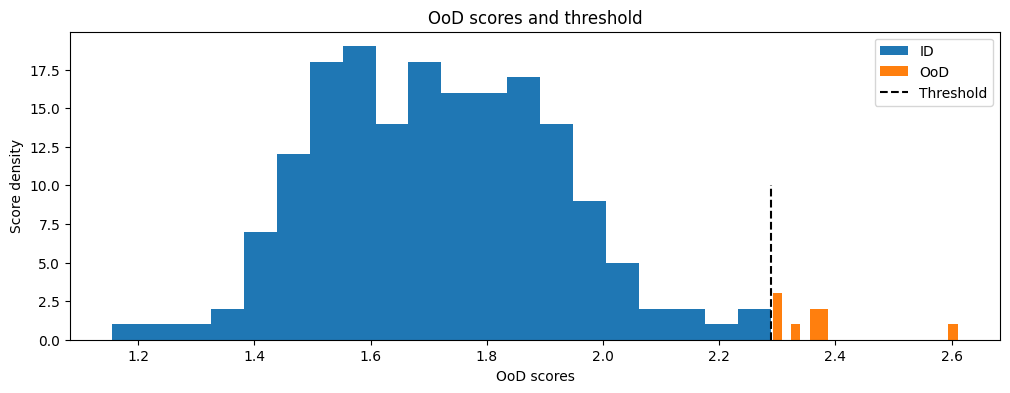

In [21]:
################################################################
############################ TEST ##############################
################################################################

# Plot ood scores and threshold
classifier, threshold_val, val_y_ood_scores = fit_knn(best_k, train_x, train_y, val_x, val_y)
plot_ood_scores(ood_scores=val_y_ood_scores, threshold=threshold_val)

* **Q4 (1 pt)**: We evaluate your classifier on the test set like in `1.2 Q4`. Is it better than Mahalanobis distance? Why?
    * **Answer**: The k-NN classifier show a stronger ability to identify true positive tumor cases compared to the Mahalanobis distance-based model. Similarly, it achieves a slightly better recall for stroma. However, when it comes to detecting out-of-distribution (OoD) samples, the Mahalanobis distance-based model outperforms k-NN, making it less likely to overlook a potential tumor by a significant margin. Based on this, the Mahalanobis distance-based model can be considered the better choice.

In [22]:
################################################################
############################ TEST ##############################
################################################################

# Predictions on test set
eval_test_knn(classifier, compute_metrics, test_x,test_y,threshold_val)

Tumor recall: 96.77%
Stroma recall: 100.00%
OoD recall: 80.65%
Average recall: 92.47%


## Part 2 - Lung Adenocarcinoma Classification (19 points)

In the previous exercise, we successfully detected TUMOR and STROMA tissues using a minimum of labels. This allows us to compute the Tumor-Stroma Ratio (TSR), a valuable indicator for determining tumor grade and guiding treatment decisions. However, despite saving annotations, the need for hundreds of tumor/stroma annotations remains prohibitively expensive. Additionally, associating the TSR value with the correct tumor grade and treatment necessitates further algorithmic developments.

An alternative approach involves annotating entire tumor grades on Whole Slide Images (WSIs) and training a classifier directly. However, a significant challenge arises due to the immense size of WSIs, typically containing millions of pixels, which makes direct preprocessing infeasible for computers. To address this challenge, we partition the WSI into thousands of non-overlapping patches. Consequently, each WSI comprises thousands of patch features. However, classifying a conglomerate of features is inherently challenging, especially considering that each WSI may not necessarily contain the same number of patches.

As illustrated in Fig. 2, a highly effective method is to apply an aggregation pooling function, which transforms the pool of features into a single slide feature. Subsequently, we can train a simple classifier to classify the slides. In this section, your objective is to develop a classifier and various pooling methods for classifying WSIs of lung adenocarcinoma patterns.

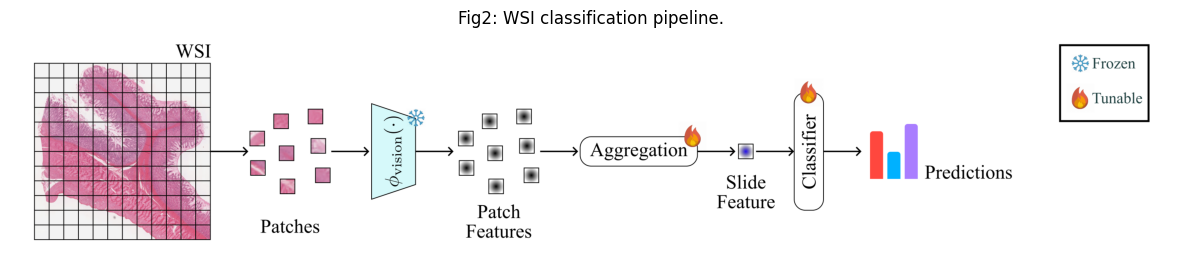

In [23]:
show_figure("../data/data_lab_03/part_02/wsi.png","Fig2: WSI classification pipeline.",(15,4))

### 2.1 Dataset [1 pt]

Your objective is to classify lung adenocarcinoma patterns, specifically acinar and solid patterns. Acinar adenocarcinoma typically exhibits glandular structures resembling small sacs when viewed under a microscope, as depicted in Fig. 3. These structures may appear irregular and crowded. Conversely, solid adenocarcinoma, as illustrated in Fig. 4, appears as solid sheets or nests of cells with little to no glandular differentiation.

You'll be working with a subset of the DHMC dataset, comprising 53 acinar examples and 48 solid examples. To assist you, we provide a training set and a validation set, representing 60% and 40% of the data, respectively. In this dataset, features of the patches composing each Whole Slide Image (WSI) have already been extracted using CTransPath. Your initial task is to prepare the data to be suitable for model training.

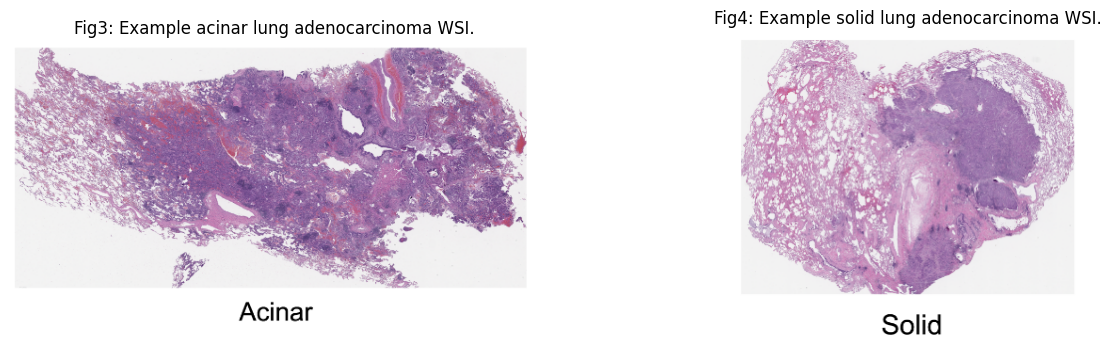

In [24]:
show_2_figures("../data/data_lab_03/part_02/acinar.png","Fig3: Example acinar lung adenocarcinoma WSI.","../data/data_lab_03/part_02/solid.png","Fig4: Example solid lung adenocarcinoma WSI.",(15,4))

* **Q1 (1 pt)**: Please complete the `DHMC2Cls` class. The class loads raw data from an external file and stores them in `raw_data`. You are required to implement the `__len__` and `__getitem__` functions. The `__len__` function should return the length M of the dataset, while the `__getitem__` function should return a tuple containing: (1) the patch features, (2) the WSI label, (3) the WSI id, and (4) the patch coordinates. Before proceeding take time to investigate the content of the raw data. It's important to note that in the training mode, you should only return the features and the label.

In [25]:
class DHMC2Cls(Dataset):
    """DHMC dataset using 2 classes"""

    def __init__(self, features_path : str, train : bool = False) -> None:
        """
        Attributes:
            raw_data (list of dict): (M) List of M slides raw data as dictionaries. 
            train (bool): True if data are the training set. False otherwise
            
        Args:
            features_path (str): The path to the features file
            train (bool): Whether it is the training dataset or not
        """
        
        super().__init__()
        # Load raw data from path
        self.raw_data = torch.load(features_path, weights_only=False)
        # Set if training or not
        self.train = train

    def __len__(self) -> int:
        """Returns the length of the dataset

        Returns:
            int: The length M of the dataset
        """

        n_data = 0
        
        # ------------------
        n_data = len(self.raw_data)
        # ------------------
        
        return n_data
    
    def __getitem__(self, index : int):
        """Returns the entry at index from the dataset

        Args:
            index (int): the requested entry index of the dataset

        Returns:
            features (torch.Tensor): (N, d) Feature tensor of the selected slide with N patches and d feature dimensions
            label (int): Ground truth label {0, ..., n_classes}
            wsi_id (str): Name of the WSI as "DHMC_xxx" where xxx is a unique id of the slide (train == False only)
            coordinates (torch.Tensor): (N, 2) xy coordinates of the N patches of the selected slide (train == False only)
        """

        features = None
        label = None
        wsi_id = None
        coordinates = None
        
        # ------------------
        data_entry = self.raw_data[index]
        features = data_entry['patch_features']
        label = data_entry['label']
        wsi_id = data_entry['wsi_id']
        coordinates = data_entry['patch_coordinates']
        # ------------------
        
        if self.train:
            return features, label
        else:
            return features, label, wsi_id, coordinates

In the cell below, we create the dataset using DHMC2Cls and we test your training and validation datasets to check for inconsistencies. Your implementation should pass all tests. 

In [26]:
################################################################
############################ TEST ##############################
################################################################

train_loader, val_loader = create_dataset(DHMC2Cls)

Successful :)


### 2.2 Average Pooling [1 pt]

You will start with the simplest pooling method, i.e. average pooling. It simply consists of averaging the WSI patch features to form a single one representative of the WSI.

* **Q1 (1 pt)**: Complete the `forward` function in `AveragePooling`. Remember, it takes a set of WSI features with shape `(N x d)`, and should return a single WSI feature of shape `(1 x d)`.

In [27]:
class AveragePooling(nn.Module):

    def __init__(self) -> None:
        super().__init__()

    def forward(self, features : torch.Tensor):
        """ Perform mean along the first dimension of the tensor

        Args:
            features (torch.Tensor): (N, D) Feature to perform average pooling on
        Return:
            mean (torch.Tensor): (1, D) Features average over all patches
        """

        mean = None
        
        # ------------------
        mean = features.mean(dim=0, keepdim=True)
        # ------------------
        
        return mean

In [28]:
################################################################
############################ TEST ##############################
################################################################

sanity_check_avg(AveragePooling)

'Successful :)'

### 2.3 Classifier [8 pts]

Now that you have coded your first aggregation method, let's build the linear classifier.

* **Q1 (3 pts)**: 
    * Complete the `Classifier` class below. You should fill `__init__` which assigns the attributes. Attributes are :
        * `proj` is a nonlinear projection layer that adapts the features for the task. It is simply a linear layer that projects features of dimension `d` to features of lower dimension `H`. Then it is followed by a ReLU.
        * `pool`, the pooling function.
        * `fc`, the final linear classifier layer. 
    * Complete `forward` which given a pool of features of shape `(1 x N x d)` outputs the class prediction logits of shape `(1 x 2)`.

In [29]:
class LinearClassifier(nn.Module):

    def __init__(self, in_dim : int, H : int, n_classes : int, pooling_fn : nn.Module) -> None:
        """Constructs the linear classifier

        Attributes:
            proj (Callable): Projection of layer (N, d) -> (N, H)
            pool (Callable): Pooling layer (N, H) -> (1, H)
            fc (Callable): Classification layer (1, H) -> (1, n_classes)
            
        Args:
            in_dim (int): The dimension of input features
            H (int): Target dimension for the projection layer
            n_classes (int): The number of classes for the task
            pooling_fn (nn.Module): The pooling function to aggregate the features
        """
        super().__init__()

        proj_layer = None
        pool_layer = None
        fc_layer = None
        
        # ------------------
        proj_layer = nn.Sequential(nn.Linear(in_dim, H), nn.ReLU())

        pool_layer = pooling_fn

        fc_layer = nn.Linear(H, n_classes)
        # ------------------

        self.proj = proj_layer
        self.pool = pool_layer
        self.fc = fc_layer
        

    def forward(self, x):
        """Forward path

        Args:
            x (torch.Tensor): (1, N, d) Input feature for a given slide with N patches
        Return:
            logits (torch.Tensor): (1, n_classes) Output logits for classification
        """

        logits = None
        
        # ------------------
        x = np.squeeze(x, 0)
        x = self.proj(x)
        x = self.pool(x)
        logits = self.fc(x)
        # ------------------

        return logits

In [30]:
################################################################
############################ TEST ##############################
################################################################

sanity_check_cls(LinearClassifier,AveragePooling)

'Successful :)'

The classifier is ready to train. It remains to write the code to optimize your model.

* **Q2 (2 pts)**: Please complete the `train` function below. This function should take `train_loader`, `val_loader`, `n_epochs`, and an `optimizer` as inputs. It is responsible for training the `model` and returning the best model checkpoint, best F1 score, and the epoch at which the best F1 score was achieved on the validation set.

**Notes**: 
* Refer to this [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for guidance on training a classifier.
* To obtain the model checkpoint, simply call `model.state_dict()`.
* We provide you the `test` function, in utils file, that computes the F1 score on a given test dataset. **You should not modify it !!!**

In [31]:
def train(model : nn.Module, train_loader : DataLoader, val_loader : DataLoader, n_epochs : int, optimizer : torch.optim.Optimizer):
    """Trains the neural network self.model for n_epochs using a given optimizer on the training dataset.
    Outputs the best model in terms of F1 score on the validation dataset.

    Args:
        model (nn.Module): The model to train
        train_loader (DataLoader): The training dataloader to iterate on the training dataset
        val_loader (DataLoader): The validation dataloader to iterate on the validation dataset
        n_epochs (int): The number of epochs, i.e. the number of time the model should see each training example
        optimizer (torch.optim.Optimizer): The optimizer function to update the model parameters

    Returns:
        best_model (nn.Module): Best model state dictionary 
        best_f1 (float): Best F1-score on the validation set
        best_epoch (int): Best epoch on validation set
        val_f1s (list of floats): (n_epochs, ) F1-scores for all epochs
        val_losses (list of floats): (n_epochs, ) Losses for all validation epochs
        train_losses(list of floats): (n_epochs, ) Losses for all training epochs
    """

    # Initialize variable to return
    best_model = model.state_dict()
    best_epoch = 0
    best_f1 = 0
    train_losses = []
    val_losses = []
    val_f1s = []

    # ------------------
    #model.train()
    for epoch in range(1, n_epochs + 1):
        total_train_loss = 0
        # print(train_loader.dataset)

        for inputs, labels in train_loader:
            # print(inputs.shape)
            # print(labels.shape)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(average_train_loss)

        # Validation evaluation
        val_f1, val_loss = test(model, val_loader)
        val_f1s.append(val_f1)
        val_losses.append(val_loss)

        # Update best model if current model is better
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_epoch = epoch
            best_model = model.state_dict()

        print(f"Epoch {epoch}/{n_epochs}, Train Loss: {average_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")
    print('Finished Training')
    # ------------------
    
    return best_model, best_f1, best_epoch, val_f1s, val_losses, train_losses

* **Q3 (1 pt)**: Train a linear classifier using `AveragePooling` for `30` epochs, employing the `Adam` optimizer with a learning rate of `1e-3`. No need to search for optimal hyperparameters. Refer to the PyTorch documentation for guidance on constructing your optimizer. Use `H=512`. Don't worry, the training might take ~10-15 minutes.

In [32]:
# Set seed for reproducibility
torch.manual_seed(0)

d, H, n_classes = None, None, None
epochs = None
model = None
optimizer = None

# ------------------
# Define model parameters
epochs = 30
d, H, n_classes = 768, 512, 2

# Create Linear classifier and optimizer
model = LinearClassifier(in_dim=d, H=H, n_classes=n_classes, pooling_fn=AveragePooling())
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ------------------


Epoch 1/30, Train Loss: 0.7001, Val Loss: 0.6234, Val F1: 0.7737
Epoch 2/30, Train Loss: 0.6311, Val Loss: 0.4744, Val F1: 0.7566
Epoch 3/30, Train Loss: 0.5761, Val Loss: 0.4622, Val F1: 0.7253
Epoch 4/30, Train Loss: 0.5492, Val Loss: 0.3981, Val F1: 0.8465
Epoch 5/30, Train Loss: 0.4769, Val Loss: 0.3712, Val F1: 0.8743
Epoch 6/30, Train Loss: 0.4564, Val Loss: 0.3729, Val F1: 0.8500
Epoch 7/30, Train Loss: 0.3969, Val Loss: 0.3875, Val F1: 0.8240
Epoch 8/30, Train Loss: 0.4165, Val Loss: 0.2908, Val F1: 0.8743
Epoch 9/30, Train Loss: 0.4457, Val Loss: 0.3341, Val F1: 0.8496
Epoch 10/30, Train Loss: 0.3374, Val Loss: 0.3062, Val F1: 0.8749
Epoch 11/30, Train Loss: 0.3295, Val Loss: 0.2919, Val F1: 0.8485
Epoch 12/30, Train Loss: 0.2888, Val Loss: 0.2783, Val F1: 0.8743
Epoch 13/30, Train Loss: 0.3185, Val Loss: 0.4506, Val F1: 0.7867
Epoch 14/30, Train Loss: 0.2644, Val Loss: 0.3316, Val F1: 0.8749
Epoch 15/30, Train Loss: 0.2360, Val Loss: 0.2897, Val F1: 0.8222
Epoch 16/30, Train 

OrderedDict([('proj.0.weight',
              tensor([[-0.0062,  0.0293, -0.0237,  ..., -0.0271, -0.0008,  0.0245],
                      [-0.0337, -0.0079,  0.0122,  ..., -0.0134, -0.0113, -0.0320],
                      [-0.0003, -0.0494,  0.0906,  ...,  0.0202, -0.0137,  0.0517],
                      ...,
                      [ 0.0230, -0.0112, -0.0311,  ..., -0.0181,  0.1687, -0.0443],
                      [ 0.0153, -0.0049,  0.0268,  ..., -0.0105, -0.0072,  0.0252],
                      [ 0.0884,  0.0591,  0.0463,  ..., -0.0349,  0.0145, -0.0288]])),
             ('proj.0.bias',
              tensor([ 0.0021, -0.0310, -0.0347,  0.0362,  0.0009, -0.0105, -0.0394, -0.0338,
                      -0.0096,  0.0228, -0.0504, -0.0130,  0.0009, -0.0110,  0.0020,  0.0129,
                      -0.0162,  0.0089,  0.0106,  0.0142, -0.0109,  0.0223, -0.0049, -0.0331,
                      -0.0234,  0.0283, -0.0030, -0.0418,  0.0255, -0.0343, -0.0299, -0.0198,
                      -0.0230,

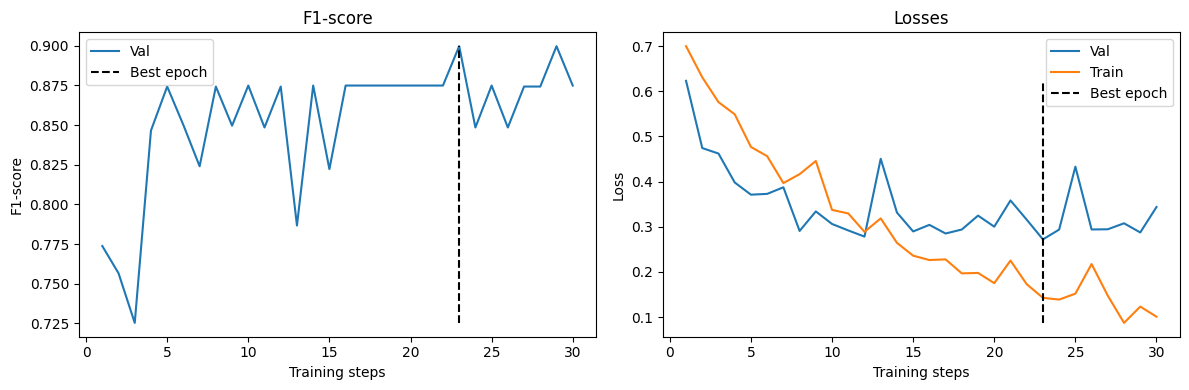

In [33]:
################################################################
############################ TEST ##############################
################################################################

# Train and Plot results
plot_training(model, train, train_loader, val_loader, epochs=epochs, optimizer=optimizer)

* **Q4 (1 pt)**: Are you satisfied with the results? What is the primary disadvantage of employing average pooling? Does the model overfit the data? (justify)
    * **Answer**: We're not satisfied with the results. The training loss is significantly lower than the validation loss, indicating overfitting. The average pooling seems to blur the patch information, preventing the model from effectively learning the patterns.

### 2.4 Attention Pooling [9 pts]

Now you will build a more advanced pooling method, called attention pooling. The motivation for this method should result from your analysis in `2.3 Q4`. So we will not share much information with you on this one. Instead, we refer you to the related paper [here](https://arxiv.org/pdf/1802.04712.pdf).

* **Q1 (4 pts)**: Complete `Attn_Net_Gated` which implements the gated attention mechanism described in the paper. Note `L`, and `M` are the dimension of the projection weights. You will find similar notations in the paper.

In [34]:
class Attn_Net_Gated(nn.Module):
    def __init__(self, L : int, M : int):
        """
        Attention Network with Sigmoid Gating (3 fc layers)
        Args:
            L: input feature dimension
            M: hidden layer dimension
        """
        super(Attn_Net_Gated, self).__init__()

        # ------------------
        self.U = nn.Sequential(
            nn.Linear(L, M), # matrix U
            nn.Sigmoid()
        )
        self.V = nn.Sequential(
            nn.Linear(L, M), # matrix V
            nn.Tanh()
        )
        self.attention_w = nn.Linear(M, 1)
        # ------------------

    def forward(self, x):
        """Forward path of the gated attention network

        Args:
            xin: (N, L) List of N patches and L features
        Return:
            A: (N, 1) Attention value for each patch
        """
        A = torch.zeros((1,), dtype=x.dtype)
        # ------------------
        # Passage dans les couches d'attention
        A_V = self.V(x)  # (N, K)
        A_U = self.U(x)  # (N, K)

        # Multiplication élément par élément et transformation
        A = self.attention_w(A_V * A_U)  # (N, 1)

        # Normalisation avec softmax
        A = F.softmax(A, dim=0)
        # ------------------

        return A

In [35]:
################################################################
############################ TEST ##############################
################################################################

sanity_gated(Attn_Net_Gated)

'Successful :)'

* **Q2 (3 pts)**: Complete `AttentionPooling`, which performs attention pooling with the help of the gated attention mechanism. In `forward`, you should only return the attention if `attention_only=True`.

In [36]:
class AttentionPooling(nn.Module):
    def __init__(self, L : int, M : int):
        super().__init__()
        # Intatiate the gated layer
        self.attention_net = Attn_Net_Gated(L, M)

    def forward(self, x, attention_only : bool = False):
        """Forward pass

        Args:
            x (torch.tensor): (N, L) Input feature over N patches and L features
            attention_only (bool): Say whether to return the attention or not
        Returns:
            Y (torch.Tensor): (1, N) Output, if attention_only==False
            A (torch.Tensor): (1, M) Attention values, if attention_only==True
        """

        A = None
        Y = None
        
        # ------------------
        A = self.attention_net(x).T # Using the previously defined Attn_Net_Gated
        Y = torch.mm(A, x)
        # ------------------

        # Check if need to return attention
        if attention_only:
            return A
        else:
            return Y

* **Q3 (1 pt)**: Train your linear classifier using `AttentionPooling` with `M=256`. You will train your model for `30` epochs, employing the `Adam` optimizer with a learning rate of `1e-4`. No need to search for optimal hyperparameters. Use `H=512`. Don't worry, the training should take ~5-10 minutes.

In [37]:
# Set seed for reproducibility
torch.manual_seed(0)

d, H, M, n_classes = None, None, None, None 
epochs = None 
model = None
optimizer = None 

# ------------------
epochs = 30
d, H, M, n_classes = 768, 512, 256, 2

# Create Linear classifier and optimizer
model = LinearClassifier(in_dim=d, H=H, n_classes=n_classes, pooling_fn=AttentionPooling(H, M))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ------------------


Epoch 1/30, Train Loss: 0.6902, Val Loss: 0.6679, Val F1: 0.7954
Epoch 2/30, Train Loss: 0.6705, Val Loss: 0.6355, Val F1: 0.6581
Epoch 3/30, Train Loss: 0.6406, Val Loss: 0.5783, Val F1: 0.8249
Epoch 4/30, Train Loss: 0.5718, Val Loss: 0.4975, Val F1: 0.7737
Epoch 5/30, Train Loss: 0.4787, Val Loss: 0.4139, Val F1: 0.8500
Epoch 6/30, Train Loss: 0.3858, Val Loss: 0.4072, Val F1: 0.7630
Epoch 7/30, Train Loss: 0.3653, Val Loss: 0.3474, Val F1: 0.8240
Epoch 8/30, Train Loss: 0.3381, Val Loss: 0.3388, Val F1: 0.8500
Epoch 9/30, Train Loss: 0.3063, Val Loss: 0.3234, Val F1: 0.8749
Epoch 10/30, Train Loss: 0.3065, Val Loss: 0.3212, Val F1: 0.8500
Epoch 11/30, Train Loss: 0.2602, Val Loss: 0.3193, Val F1: 0.8730
Epoch 12/30, Train Loss: 0.2770, Val Loss: 0.3277, Val F1: 0.8465
Epoch 13/30, Train Loss: 0.2434, Val Loss: 0.2894, Val F1: 0.8997
Epoch 14/30, Train Loss: 0.2147, Val Loss: 0.2922, Val F1: 0.8749
Epoch 15/30, Train Loss: 0.2421, Val Loss: 0.2827, Val F1: 0.8749
Epoch 16/30, Train 

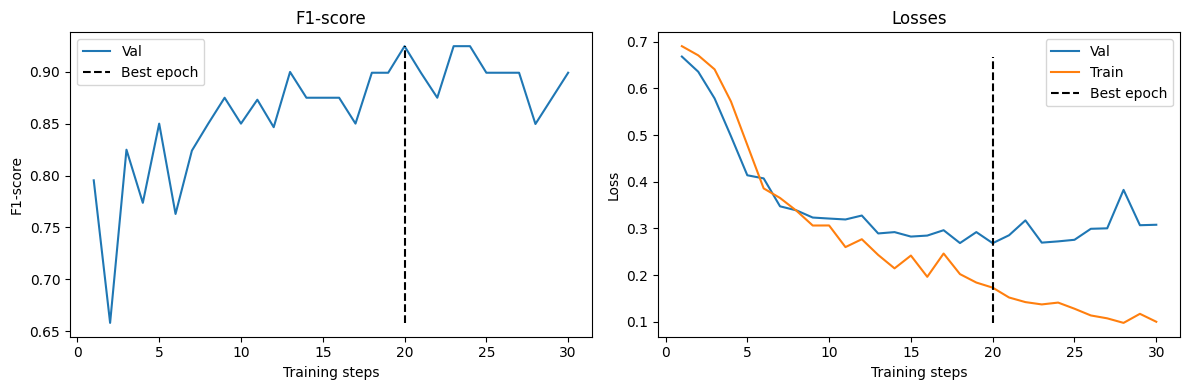

In [38]:
################################################################
############################ TEST ##############################
################################################################

# Train and Plot results
best = plot_training(model, train, train_loader, val_loader, epochs=epochs, optimizer=optimizer)

We have kept one example per class for testing and visualization. We have `DHMC_0001.jpg` presenting solid adenocarcinoma patterns and `DHMC_0007.jpg` with acinar adenocarcinoma. Those examples have never been seen in training and validation.

* **Q4 (1 pt)**: Test your best attention model on the test dataset below. Use `load_state_dict()` to load the model weights.

In [39]:
# Load test dataset
test_dataset = load_data_2(DHMC2Cls, "dhmc_test.pth")
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Create a model from the best model state
 
model = None

# ------------------
model = LinearClassifier(in_dim=d, H=H, n_classes=n_classes, pooling_fn=AttentionPooling(H, M))
model.load_state_dict(best)
test_f1, _ = test(model, test_loader)

print(f"Test F1 score: {100*test_f1:.2f}%")
# ------------------

Test F1 score: 100.00%


In [40]:
################################################################
############################ TEST ##############################
################################################################

test(model, test_loader)


(1.0, tensor(0.0397))

As stated in the paper, a benefit of incorporating an attention layer is the enhanced interpretability of the model's decision-making process. This feature is particularly crucial for ensuring the safe deployment of deep learning models, especially in sensitive domains such as the medical field. With an attention layer, it becomes possible to discern the most critical patches that the model considered for a particular decision. To visualize this, please execute the cell below to observe the attention maps on the test examples. **Don't forget to answer the question in the end !!!**

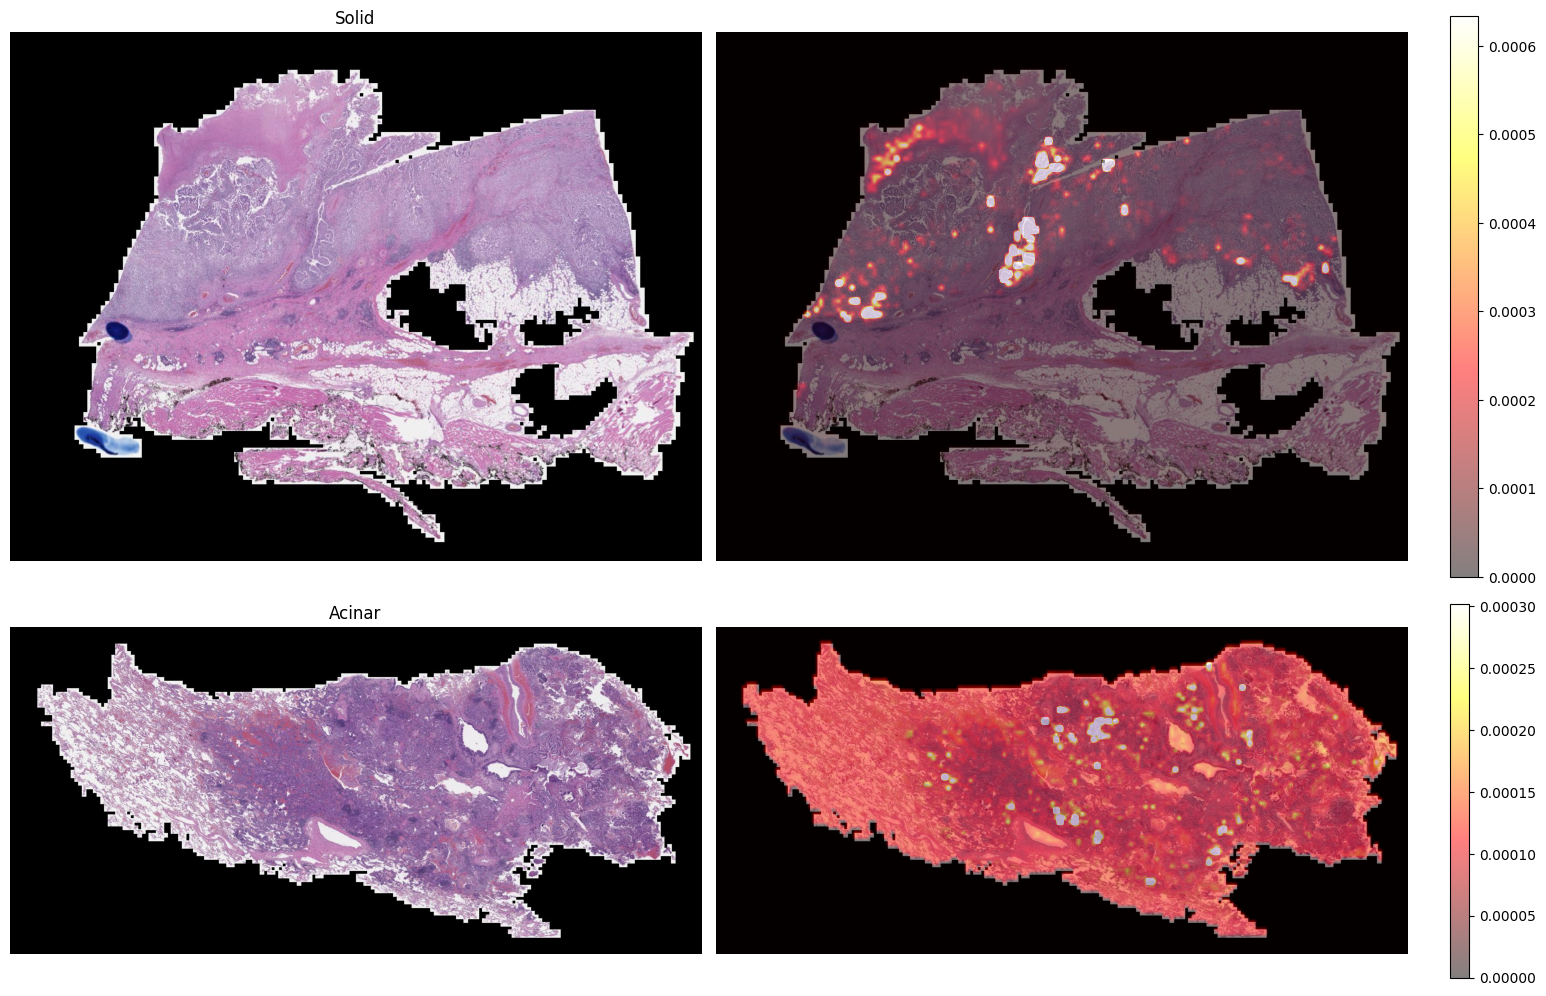

In [41]:
################################################################
############################ TEST ##############################
################################################################

plot_attention(model, test_loader)

* **Q5 (1 pt)**: From the visualization above, what can you interpret?
    * **Answer**: For the Acinar, the attention layer highlights the small dark violet patches with significantly higher intensity compared to the surrounding white and yellow areas. These patches are the primary focus for classification, as they correspond to the tumor. In the case of the Solid, the key features are less obvious, but it appears that the model emphasizes the thin white stretches visible in the attention region. These structures likely emerge due to tumor growth, which alters the surrounding tissue, making them useful cues for classification.